Notebook erstellt von harald.kreidl.riedering@freenet.de.

http://www.ee.iitm.ac.in/~nitin/teaching/ee5480/firdesign.html

https://ti.tuwien.ac.at/cps/teaching/courses/dspv/files/FIRFilter.pdf

Letzte Ausführung des Notebooks:

In [1]:
import time
print('Last updated (day.month.year): %s von Harald Kreidl' %time.strftime('%a, %d %b. %Y %H:%M:%S '))

Last updated (day.month.year): Sat, 02 Jan. 2016 22:14:22  von Harald Kreidl


In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# FIR Filter Design

## Inhaltsverzeichnis

1. [Filter Design in Python](#Filter Design in Python)<br>
2. [FIR Filters](#FIR Filters)<br>
2.1 [Definition](#Definition)<br>
2.2 [Ein Beispiel eines FIR-Filters ist das Mittelwertfilter](#Ein Beispiel eines FIR-Filters ist das Mittelwertfilter)<br>
2.3 [Allgemeine FIR-Filter](#Allgemeine FIR-Filter)<br>
2.3 [Allgemeine FIR-Filter](#Allgemeine FIR-Filter)<br>

2.2 [Requirements Specification](#Requirements Specification)<br>
2.2.1 [Sampling rate](#Sampling rate)<br>
2.2.2 [Band specification](#Band specification)<br>
2.2.3 [Cut-off frequency](#Cut-off frequency)<br>
2.2.4 [Gain/Attenuation](#Gain/Attenuation)<br>
3. [Python Basics](#Python Basics)<br>
4. [FIR Design and Simulation with Python](#FIR Design and Simulation with Python)<br>
4.1 [Input samples](#Input samples)<br>
4.2 [Frequency content](#Frequency content)<br>
4.3 [Noise](#Noise)<br>
4.4 [Filter coefficients](#Filter coefficients)<br>
4.5 [Filtering](#Filtering)<br>
4.6 [Quantization](#Quantization)<br>
5. [Lab assignment](#Lab assignment)<br>

## 1. Filter Design in Python <a id='Filter Design in Python'></a>

<p>The initial description of a filter is typically done using higher level languages: Matlab is one of the most popular languages for signal processing applications. In the present course, we will use Python (with Numeric and Scientific extensions <code>scipy</code> and <code>numpy</code> respectively) instead. The process of design will start from an initial specification, testing and tuning using Python, quantization and conversion to fixed point implementation.</p>
<p>In the following sections, we will go through this process for designing an FIR filter - portions where the code is not covered in this document need to be filled in for the lab assignment.</p>

[Zurück](#Inhaltsverzeichnis)

## 2. FIR Filters <a id='FIR Filters'></a>

### 2.1 Definition <a id='Definition'></a>

A finite impulse response (=FIR, dt.: Filter mit endlicher Impulsantwort, Nicht-rekursive Filter) filter is described by the mathematical equation
$$y(n) = \sum \limits_{i=0}^{N-1} \underbrace{h_k}_{\text{filter coefficients}} \cdot \underbrace{x(n-k)}_{\text{past samples of the input data}} $$

$N$ is the number of samples.

Here is a set of values corresponding usually to samples of some physical quantity. For example, this could be samples of an audio waveform converted to a voltage by a microphone and sampled by an analog-to-digital converter (ADC).

Digitale Filter setzen Eingangszahlenfolgen in Ausgangszahlenfolgen um.

### 2.2 Ein Beispiel eines FIR-Filters ist das Mittelwertfilter <a id='Ein Beispiel eines FIR-Filters ist das Mittelwertfilter'></a>

Als Beispiel für den Transformationsprozess eines Filters nehmen wir die Bildung des gleitenden Mittelwerts ̧über drei Punkte einer Folge: In jedem Zeitpunkt wird der Ausgangswert aus drei zeitlich zur ̧zurückliegenden Punkten der Eingangsfolge gebildet.

<table border="0" width="80%">
<tr> <td>n</td> <td>-2</td> <td>-1</td> <td>0</td> <td>1</td> <td>2</td> <td>3</td> <td>4</td> <td>5</td> <td>6</td> <td>7</td> <td>8</td> </tr>
<tr> <td>x[n]</td> <td></td> <td></td> <td>0</td> <td><b>1</b></td> <td><b>3</b></td> <td><b>2</b></td> <td>-1</td> <td>2</td> <td>0</td> <td>0</td> <td>0</td> </tr>
<tr> <td>y[n]</td> <td></td> <td></td> <td>0</td> <td>1/3</td> <td>4/3</td> <td><b>2</b></td> <td>4/3</td> <td>1</td> <td>1/3</td> <td>2/3</td> <td>0</td> </tr>
</table>

Der Ausgangswert zum Zeitpunkt n=0 wird durch Mittelung der Werte x[0,-1,-2] = [0,0,0] gebildet. Die Eingangsfolge hat zu den Zeitpunkten x[-1,-2] keine definierten Werte, wir nehmen an, dass die Folge x[n] zum Zeitpunkt n[0] beginnt und setzen die Werte für n<0 auf Null. Der Ausgangswert zum Zeitpunkt n=3 wird aus den Werten [2,3,1] --> 6/3 = 2 gebildet, u.s.w.

Wir können den Transformationsprozess von Eingangsfolge in Ausgangsfolge durch den folgenden Zusammenhang beschreiben

$$ y[n] = \frac{1}{3} {\left( x[n] + x[n-1] + x[n-2] \right)} $$

Um die Filterwirkung eines Mittelwertfilters besser verstehen zu können, erzeugen wir ein Signal, das aus einer Komponente niedriger und aus einer Komponente hoher Frequenz besteht.

$$ x[n] = A \cdot \cos \left( f_1 n \right) + \frac{A}{4} \cdot \cos \left( f_2 n \right) $$

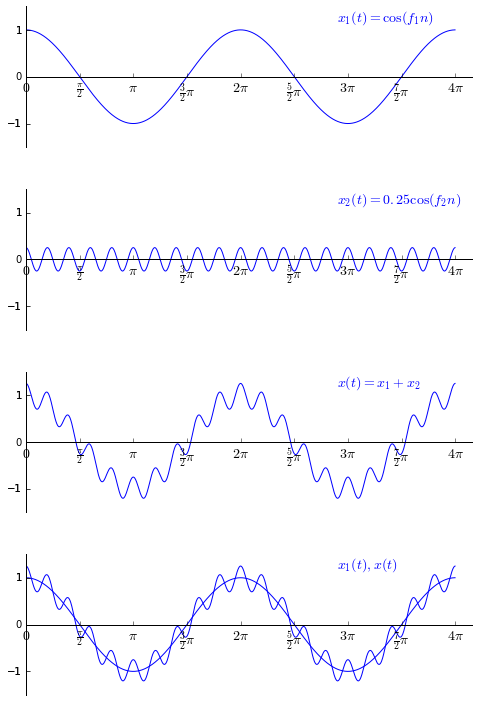

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Signal von 0 bis 4PI
n = np.arange(0, 4*np.pi, 0.01)
A = 1.0                         # Amplitude
f1 = 1.0                        # Frequenz des niedrigfrequenten Signals
f2 = 10.0                       # hochfrequentes Signal
x1 = A*np.cos(f1*n)
x2 = A/4*np.cos(f2*n)
x3 = x1 + x2
x = np.array([ [x1], [x2], [x3] ])

plt.close('all')
plotnumbers = 4
figsizex = 8
figsizey = 3*plotnumbers
fig, axs = plt.subplots(plotnumbers, sharex=True, sharey=True, figsize=(figsizex,figsizey) )
fig.subplots_adjust(wspace=0.5, hspace=0.5)

xticker = np.linspace(0, 4*np.pi, num=9, endpoint=True)
yticker = [-A, -1, 0, 1, A] 
xlabels = [r"$0$", r"$\frac{\pi}{2}$", r"${\pi}$", r"$\frac{3}{2}\pi$", \
           r"$2\pi$", r"$\frac{5}{2}\pi$", r"${3\pi}$", r"$\frac{7}{2}\pi$", r"$4\pi$"]
text = [ r"$x_1(t)=\cos(f_1 n)$",r"$x_2(t)=0.25 \cos(f_2 n)$",
                 "$x(t)=x_1 + x_2$",r"$x_1(t), x(t)$" ]
for i in range(plotnumbers):
    # Only draw spine between the y-ticks
    axs[i].spines['left'].set_bounds(-1.5, 1.5)
    # Hide the right and top spines
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    # Draw bottom spine in the center
    axs[i].spines['bottom'].set_position('center')
    # Only show ticks on the left and bottom spines
    axs[i].yaxis.set_ticks_position('left')
    axs[i].xaxis.set_ticks_position('bottom')
    # x spine labeling
    axs[i].set_xticks(xticker)
    axs[i].set_xticklabels(xlabels, size=14)
    # y spine labeling
    axs[i].set_yticks(yticker)
    # Length of x- and y-axis
    axs[i].set_xlim(0, 4*np.pi+0.5)
    axs[i].set_ylim(-A-0.3, A+0.3)
    # Curve labeling
    axs[i].text(2.9*np.pi, 1.2*A, text[i], fontsize=14, color='blue')

for i in range(plotnumbers-1):
    # Plot curves
    axs[i].plot(n, np.reshape(x[i],len(n)), linewidth="1", alpha=1, color='blue')

axs[3].plot(n, np.reshape(x[2],len(n)), linewidth="1", alpha=1, color='blue')
axs[3].plot(n, np.reshape(x[0],len(n)), linewidth="1", alpha=1, color='blue')

plt.savefig('notebook_generated_figures/sine_t.svg')
plt.savefig('notebook_generated_figures/sine_t.png')
plt.savefig('notebook_generated_figures/sine_t.jpg')
plt.show()

Die Eingangsfolge $x[n]$ filtern wir mit mit einem Mittelwertfilter über 3 Mittewerte.

$$ y[n] = \frac{1}{3} {\left( x[n] + x[n-1] + x[n-2] \right)} $$

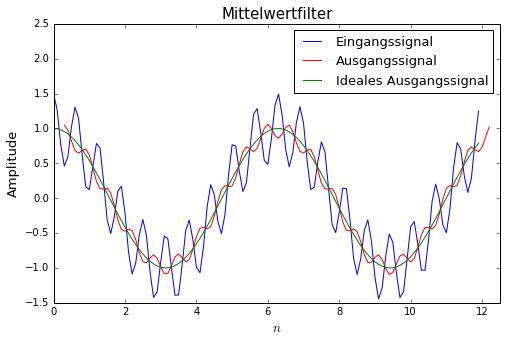

In [4]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

M = 6  # Anzahl der Mittelwerte
# Signal von 0 bis 4*PI
n = np.arange(0, 4*np.pi, 0.1)
# Ausgangsfolge erzeugen
y = np.zeros( (len(n), 1) )

f1 = 1.0                        # Frequenz des niedrigfrequenten Signals
f2 = 10.0                       # hochfrequentes Signal
A = 1.0                         # Amplitude
x1 = A*np.cos(f1*n)
x2 = A/2*np.cos(f2*n)
x3 = x1 + x2

for i in range(len(n)-M):
    y[i+M/2]= 1./7.*(x3[i]+x3[i+1]+x3[i+2]+x3[i+3]+x3[i+5]+x3[i+5]+x3[i+6])

fsize = 5
plt.close('all')
fig = plt.figure(figsize=(fsize*1.6, fsize))# a new figure window
ax = fig.add_subplot(1, 1, 1)   # specify (nrows, ncols, axnum)

ax.set_xlabel("$n$", fontsize=fsize*2.6)
ax.set_ylabel("Amplitude", fontsize=fsize*2.6)
ax.set_title("Mittelwertfilter", fontsize=fsize*3)
ax.set_ylim(-1.5, 2.5)
ax.set_xlim(0, 12.5)

ax.plot(n[:-M],x3[:len(n)-M], '-b')
ax.plot(n[M/2:-M/2],y[M/2:len(n)-M/2], '-r')
ax.plot(n[:-M],x1[:len(n)-M], '-g')
ax.legend(['Eingangssignal', 'Ausgangssignal', 'Ideales Ausgangssignal'], fontsize=fsize*2.6)

Aus der Abbildung können wir erkennen, dass am Anfang und am Ende des Ausgangssignals das Filter gefüllt bzw. geleert wird, diese Abschnitte nennt man Einschwing- und Abklingphase des Filters. Wir sehen, dass die höhere Frequenzkomponente geglättet (unterdrückt) wird. Wir können aus den Abbildungen schließen, dass das Ausmaß der Unterdrückung höherer Frequenzen davon abhängt, über wieviele Punkte der Mittelwert gebildet wird.

Ein Filterverhalten, das niedrige (tiefe) Frequenzen ungedämpft überträgt, während es hohe Frequenzen dämpft nennt man
<i>Tiefpass-Filter</i>.

[Zurück](#Inhaltsverzeichnis)

### 2.3 Allgemeine FIR-Filter <a id='Allgemeine FIR-Filter'></a>

In unserem Beispiel haben wir den Transformationsprozess zwischen Eingangs und Ausgangsignal über die Mittelwertbildung festgelegt. Für Mittelwertfilter können wir allgemein schreiben:

$$ y[n] = \frac{1}{N} \left( x[n] + x[n-1] + x[n-2] + \dots + x[n-(N-1)] \right) = \frac{1}{N} \sum \limits_{k=0}^{N-1} x[n-k] $$

Beim Mittelwertfilter haben wir für die Berechnung des Ausganswertes alle Werte der Eingangsfolge mit dem gleichen Wert $\frac{1}{N}$ multipliziert. Lassen wir bei der Berechnung der Ausgangsfolge für jeden Wert der Eingangsfolge einen eigenen Koeffizienten zu, dann erhalten wir die Filtergleichung für allgemeine FIR-Filter:

$$ y[n] = \sum \limits_{k=0}^{M} b_k x[n-k] $$

Die Größle $M$ nennt man die Ordnung des Filters. Die Zahl der Werte, die in die Berechnung der Ausgangfolge eingehen ist also immer $M+1$. Das Mittelwertfilter ist ein Tiefpass-Filter, andere Filter-Charakteristika (Durchlassen von tiefen oder hohen Frequenzen, selektives Unterdrücken von Frequenzen oder selektives Durchlassen von Frequenzen) können durch die Wahl geeigneter Koeffizienten $b_k$ erreicht werden.

Beim  FIR-Filter $M$-ter Ordnung entspricht jeder Ausgangswert einer Linearkombination der letzten $M+1$ Eingangswerte.

Anmerkung: Diskrete Systeme kennen streng genommen keinen Zeitbegriff, weil sie lediglich Folgen von Zahlen verarbeiten. Trotztem wurde hier wegen der engen Beziehung zwischen Zahlenfolgen und abgetasteten Zeitsignalen der (dimensionslose!) Folgeparameter $n$ als Zeit bezeichnet.

Damit in Python negative Indices vermieden werden, sollte $n \ge M$ sein:

$$ y[n] = \sum \limits_{k=0}^{M} b_k x[n-k] \text{ wobei gilt: } n \ge M $$

[Zurück](#Inhaltsverzeichnis)

### 2.2 Requirements Specification <a id='Requirements Specification'></a>

### 2.2.1 Sampling rate <a id='Sampling rate'></a>

 The sampling rate of a filter is usually determined by the physical quantity being sampled. For example, audio data is typically sampled at 8kHz if it is desired to have telephone conversation quality, or at above 40kHz if music is being digitized. This depends on the bandwidth of the signal.

We do not need to concern ourselves with the actual sampling rate for a digital filter, since the entire design is done relative to the sampling frequency $ f_s $.

<b>Exercise</b>: If a digital low-pass filter is designed for a sampling frequency of $ f_s = 1000 \mathrm{Hz} $ and cutoff frequency $ f_c = 200 \mathrm{Hz} $, then if we use the same coefficients on a sampling frequency of $ f_s = 1000 \mathrm{Hz} $ , what cutoff frequency does that correspond to?

As a result, we normalize $ f_s $ to for the design process. 

[Zurück](#Inhaltsverzeichnis)

### 2.2.2 Band specification <a id='Band specification'></a>

<p>   A filter can be low-pass, high-pass, band-pass or band-stop
   (all-pass filters or more complex filters with multiple pass/stop
   bands are also possible of course).  For the present problem, we
   are designing a <b>low-pass</b> filter.
</p>

### 2.2.3 Cut-off frequency <a id='Cut-off frequency'></a>

For a low-pass filter, we need to specify a single cutoff frequency $ f_c$. Frequencies above this are <i>attenuated</i> while frequencies below this are <i>passed through</i>.  This defines the <i>stop-band</i> and <i>pass-band</i> respectively.

### 2.2.4 Gain/Attenuation <a id='Gain/Attenuation'></a>

The pass band gain is usually assumed to be unity (1.0), meaning
   that a signal in the pass-band goes through without being amplified
   or reduced.  It is of course possible to have amplification also,
   but this is usually treated separately and not as part of the
   filter.  However, keep in mind that the choice of filter
   coefficients and how they are normalized/quantized can have an
   effect on the pass-band gain.
</p>
<p>
   The stop-band signal needs to be attenuated or suppressed.  The
   degree of attenuation is usually specified in <code>dB</code> (deciBels).  For
   example, a 40dB attenuation means that $ 20 \log \frac{V_o}{V_i} = - 40 $.
   
<b>Exercise</b>: 
</p><ul>
<li>Why $ 20 \log $ and not $ 10 \log $? </li>
<li>Why $ -40 $ and not $ +40 $? </li>
</ul>

[Zurück](#Inhaltsverzeichnis)

## 3. Python Basics <a id='Python Basics'></a>

<p>  <code>python</code> is a programming language that can, among other things, be
  used for the numerical computations required for designing filters.
  An introduction to the language is outside the scope of this
  tutorial: for now, you can complete the assignment without needing
  to learn much of the language.  However, it is strongly recommended
  as a useful skill to have for anyone interested in digital design.
</p>

[Zurück](#Inhaltsverzeichnis)

## 4. FIR Design and Simulation with Python <a id='FIR Design and Simulation with Python'></a>

<p>  We now provide a set of basic operations for the following steps:
</p><ul>
<li>Creating a set of samples to be used as input for the filter
</li>
<li>Importing necessary modules for designing the filter
</li>
<li>Functions for quantizing coefficients and data
</li>
</ul>

[Zurück](#Inhaltsverzeichnis)

### 4.1 Input samples <a id='Input samples'></a>

<p>   We first need to create a time base (set of time instants at which
   we are sampling the data), and then generate the corresponding data
   at those time instants.  For simplicity, we will assume a sampling
   rate of 1000 Hz for this discussion, but it should be clear to you
   by now that this is just a question of normalization.
</p>

1000


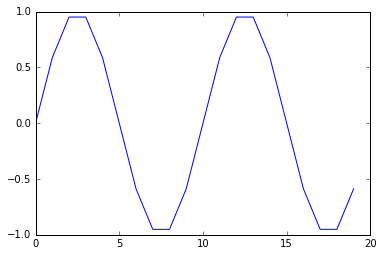

In [5]:
# 1 second of data samples at spacing of 1/1000 seconds
t = np.arange(0, 1, 1.0/1000)
print len(t)
# sine wave of 100 Hz
s = np.sin(2 * np.pi * 100 * t)
# plot first 20 points of the resulting data (why not all 1000?)
plt.plot(s[:20])
plt.show()

[Zurück](#Inhaltsverzeichnis)

### 4.2 Frequency content <a id='Frequency content'></a>

<p>   Use the <code>fft</code> command to find the Fourier Transform of the signal,
   giving it's frequency content.  Note that unless you normalize by
   the length of the FFT, the amplitude that you get will not be
   correct.  
</p>

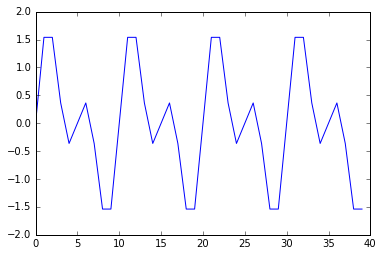

In [6]:
# 1 second of data samples at spacing of 1/1000 seconds
t = np.arange(0, 1, 1.0/1000)
# Another signal with two sine waves
s = np.sin(2*np.pi*100*t)+np.sin(2*np.pi*200*t)
plt.plot(s[:40])
plt.show()

1000


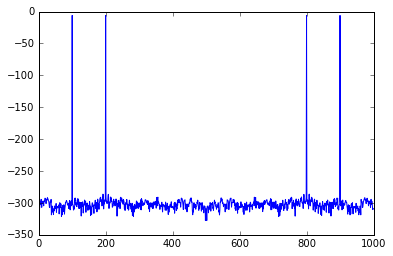

In [7]:
# 1 second of data samples at spacing of 1/1000 seconds
t = np.arange(0, 1, 1.0/1000)
# Another signal with two sine waves
s = np.sin(2*np.pi*100*t)+np.sin(2*np.pi*200*t)
# Note: you may need to use fft.fft if you are using ipython
print len(s)
ft = np.fft.fft(s)/len(s)
plt.plot(20*np.log10(np.abs(ft)))
plt.show()

<p>
   <b>Exercise</b>: 
</p><ul>
<li>Why is the peak amplitude the value that you see?
</li>
<li>Why is there a noisy floor?
</li>
<li>Change the time base to the following and repeat the above steps. Why does the FFT look so different?
</li>
</ul>

1001


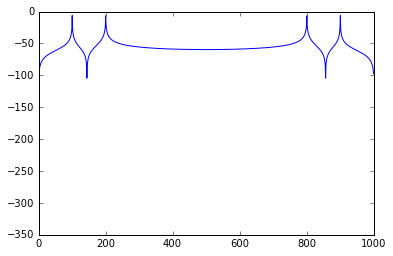

In [8]:
t=np.arange(0, 1.001, 1.0/1000)
# Another signal with two sine waves
s = np.sin(2*np.pi*100*t)+np.sin(2*np.pi*200*t)
# Note: you may need to use fft.fft if you are using ipython
print len(s)
ft = np.fft.fft(s)/len(s)
plt.plot(20*np.log10(np.abs(ft)))
plt.show()

[Zurück](#Inhaltsverzeichnis)

### 4.3 Noise <a id='Noise'></a>

<p>   Add noise to the generated signal as follows:
</p>

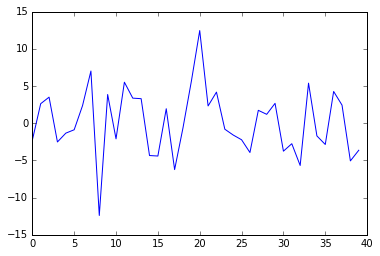

In [9]:
# 1 second of data samples at spacing of 1/1000 seconds
t = np.arange(0, 1, 1.0/1000)
noise_amp = 5.0
s = np.sin(2*np.pi*100*t)+np.sin(2*np.pi*200*t)+noise_amp * np.random.randn(len(t))
plt.plot(s[:40])
plt.show()

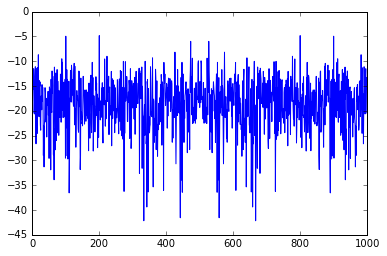

In [10]:
ft = np.fft.fft(s)/len(s)
plt.plot(20*np.log10(np.abs(ft)))
plt.show()

[Zurück](#Inhaltsverzeichnis)

### 4.4 Filter coefficients <a id='Filter coefficients'></a>

<p>   You need to design a filter that will suppress the 200Hz component
   by at least 30dB while leaving the 100Hz component alone.  The
   commands given below will design a filter with passband between 0
   to 200 and stop band from 300 to 500 (half the sampling frequency
   of 1000Hz).  Modify this to get a suitable filter.  
</p>

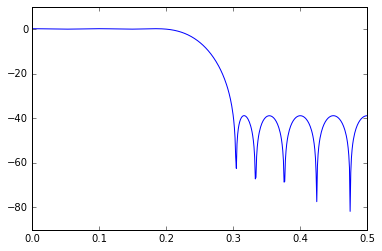

In [11]:
from scipy.signal import remez
lpf = remez(21, [0, 0.2, 0.3, 0.5], [1.0, 0.0])
from scipy.signal import freqz
w, h = freqz(lpf)
plt.plot(w/(2*np.pi), 20*np.log10(np.abs(h)))
plt.show()

<p>
   <b>Exercise</b>:
</p><ul>
<li>What is the attenuation of the above figure in the stopband?
</li>
<li>What happens if you reduce the number of taps to 5?
</li>
<li>How many taps do you need for your filter for a 30dB stopband
     attenuation?
</li>
<li>What happens to signals in the range 200-300Hz with the above
     filter?
</li>
</ul>

[Zurück](#Inhaltsverzeichnis)

### 4.5 Filtering <a id='Filtering'></a>

<p>   Actually applying the filter to the input signal is very easy: just
   use the <code>lfilter</code> command:
</p>

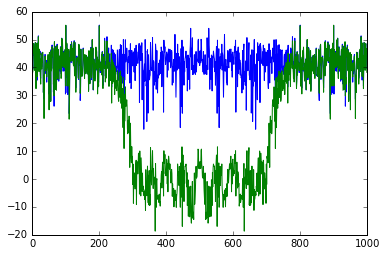

In [12]:
from scipy.signal import lfilter
sout = lfilter(lpf, 1, s)
plt.plot(20*np.log10(abs(np.fft.fft(s))))
plt.plot(20*np.log10(abs(np.fft.fft(sout))))
plt.show()

What does the filtered signal look like? 

[Zurück](#Inhaltsverzeichnis)

### 4.6 Quantization <a id='Quantization'></a>

<p>   The simulations so far are working with floating point numbers.
   Practical systems need to work with finite precision numbers
   (fixed-point).  A simple way of understanding fixed point is to
   scale all the real-valued numbers by some constant <span style="display: none;" class="MathJax_Preview"></span><span style="" aria-readonly="true" role="textbox" class="MathJax"><nobr style=""><span id="MathJax-Span-1" class="math"><span style="display: inline-block; position: relative; width: 0.58em; height: 0px; font-size: 115%;"><span style="position: absolute; top: -2.217em; left: 0em; clip: rect(1.349em, 1000em, 2.413em, -0.47em);"><span id="MathJax-Span-2" class="mrow"><span id="MathJax-Span-3" class="mi"><img style="width: 11px; height: 11px; margin-right: -0.032em;" src="http://orgmode.org/mathjax/fonts/HTML-CSS/TeX/png/Math/Italic/120/0053.png"></span></span><span style="display: inline-block; width: 0px; height: 2.217em;"></span></span></span><span style="border-left: 0em solid; display: inline-block; overflow: hidden; width: 0px; height: 0.824em; vertical-align: -0.025em;"></span></span></nobr></span><script id="MathJax-Element-1" type="math/tex">S</script> and round
   off the result to the nearest integer.  Then, after finishing your
   computations, remove the scaling factor, and you get back the data
   in the same range of real-valued numbers as you started with.  
</p>
<p>
   A good choice of scaling factor (for ease of hardware
   implementation) is <span style="display: none;" class="MathJax_Preview"></span><span style="" aria-readonly="true" role="textbox" class="MathJax"><nobr style=""><span id="MathJax-Span-4" class="math"><span style="display: inline-block; position: relative; width: 3.014em; height: 0px; font-size: 115%;"><span style="position: absolute; top: -2.217em; left: 0em; clip: rect(1.349em, 1000em, 2.413em, -0.47em);"><span id="MathJax-Span-5" class="mrow"><span id="MathJax-Span-6" class="mi"><img style="width: 11px; height: 11px; margin-right: -0.032em;" src="http://orgmode.org/mathjax/fonts/HTML-CSS/TeX/png/Math/Italic/120/0053.png"></span><span style="padding-left: 0.278em;" id="MathJax-Span-7" class="mo"><img style="width: 12px; height: 4px; vertical-align: 2px; margin-right: 0.055em;" src="http://orgmode.org/mathjax/fonts/HTML-CSS/TeX/png/Main/Regular/120/003D.png"></span><span style="padding-left: 0.278em;" id="MathJax-Span-8" class="msubsup"><span style="display: inline-block; position: relative; width: 1.078em; height: 0px;"><span style="position: absolute; top: -2.217em; left: 0em; clip: rect(1.387em, 1000em, 2.392em, -0.473em);"><span id="MathJax-Span-9" class="mn"><img style="width: 8px; height: 12px; margin-right: 0.05em;" src="http://orgmode.org/mathjax/fonts/HTML-CSS/TeX/png/Main/Regular/120/0032.png"></span><span style="display: inline-block; width: 0px; height: 2.217em;"></span></span><span style="position: absolute; top: -2.601em; left: 0.597em;"><span style="font-size: 70.7%;" id="MathJax-Span-10" class="mi"><img style="width: 7px; height: 5px; margin-right: 0.02em;" src="http://orgmode.org/mathjax/fonts/HTML-CSS/TeX/png/Math/Italic/085/006E.png"></span><span style="display: inline-block; width: 0px; height: 2.217em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.217em;"></span></span></span><span style="border-left: 0em solid; display: inline-block; overflow: hidden; width: 0px; height: 0.824em; vertical-align: -0.025em;"></span></span></nobr></span><script id="MathJax-Element-2" type="math/tex">S=2^n</script> where n is some integer.  This has the
   benefit that the multiplication and division can be done simply by
   left- or right-shifting binary numbers.
</p>
<p>
   A <code>N.M</code> fixed point number has <code>N</code> bits representing the integer
   part, and <code>M</code> bits representing the fractional part.  This means
   that the range of values that can be represented using this number
   are between + and - <span style="display: none;" class="MathJax_Preview"></span><span style="" aria-readonly="true" role="textbox" class="MathJax"><nobr style=""><span id="MathJax-Span-11" class="math"><span style="display: inline-block; position: relative; width: 1.275em; height: 0px; font-size: 115%;"><span style="position: absolute; top: -2.217em; left: 0em; clip: rect(1.184em, 1000em, 2.392em, -0.473em);"><span id="MathJax-Span-12" class="mrow"><span id="MathJax-Span-13" class="msubsup"><span style="display: inline-block; position: relative; width: 1.251em; height: 0px;"><span style="position: absolute; top: -2.217em; left: 0em; clip: rect(1.387em, 1000em, 2.392em, -0.473em);"><span id="MathJax-Span-14" class="mn"><img style="width: 8px; height: 12px; margin-right: 0.05em;" src="http://orgmode.org/mathjax/fonts/HTML-CSS/TeX/png/Main/Regular/120/0032.png"></span><span style="display: inline-block; width: 0px; height: 2.217em;"></span></span><span style="position: absolute; top: -2.601em; left: 0.597em;"><span style="font-size: 70.7%;" id="MathJax-Span-15" class="mi"><img style="width: 11px; height: 9px; margin-right: -0.084em;" src="http://orgmode.org/mathjax/fonts/HTML-CSS/TeX/png/Math/Italic/085/004E.png"></span><span style="display: inline-block; width: 0px; height: 2.217em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.217em;"></span></span></span><span style="border-left: 0em solid; display: inline-block; overflow: hidden; width: 0px; height: 0.989em; vertical-align: -0.001em;"></span></span></nobr></span><script id="MathJax-Element-3" type="math/tex">2^N</script>, but with <code>M</code> bits of fractional
   precision. 
</p>
<p>
   For example:
</p><table rules="groups" frame="hsides" border="2" cellpadding="6" cellspacing="0">
<caption></caption>
<colgroup><col class="center"><col class="center"><col class="center"><col class="center">
</colgroup>
<thead>
<tr><th scope="col" class="center">Representation</th><th scope="col" class="center">Total bits</th><th scope="col" class="center">min</th><th scope="col" class="center">max</th></tr>
</thead>
<tbody>
<tr><td class="center">8.0</td><td class="center">8</td><td class="center">-128</td><td class="center">+127</td></tr>
<tr><td class="center">1.7</td><td class="center">8</td><td class="center">-1.0</td><td class="center">0.9921875 (127/128)</td></tr>
<tr><td class="center">3.7</td><td class="center">10</td><td class="center">-8.0</td><td class="center">7.984375 (8*511/512)</td></tr>
</tbody>
</table>


<p>
   <b>Exercise</b>: 
</p><ul>
<li>Quantize the inputs to 8 bits total.  What is the minimum number
     of bits you need on the integer side?
</li>
<li>Quantize the coefficients to as few bits as possible so that you
     still get a 30dB attenuation of the 200Hz signal.  How many bits
     are you able to reduce the result to?
</li>
</ul>

[Zurück](#Inhaltsverzeichnis)

## 5 Lab assignment <a id='Lab assignment'></a>

<ul>
<li>Generate a suitable FIR low pass filter as per the specifications
    above, and submit a report containing the frequency response,
    coefficients, and frequency plots of the original and filtered
    signals. 
</li>
<li>Answer all the questions marked <b>Exercise</b> in the above
    description.
</li>
</ul>

[Zurück](#Inhaltsverzeichnis)